# Assignment #10 [ERA v2]

### Objective
In this assignment we are going to train the CIFAR10 dataset to achieve 90% validation accuracy using RESNET Architecture in 24 epoch.


### Step 1: Import the required modules

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets

### Step 2: Preparing the Training and Testing Data

#### 2.0: View the Test and Training DataSet

100%|██████████| 170498071/170498071 [00:04<00:00, 41211262.55it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
CIFAR classes : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


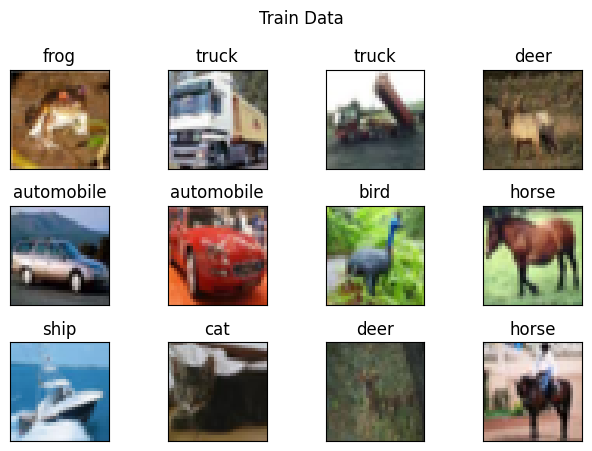

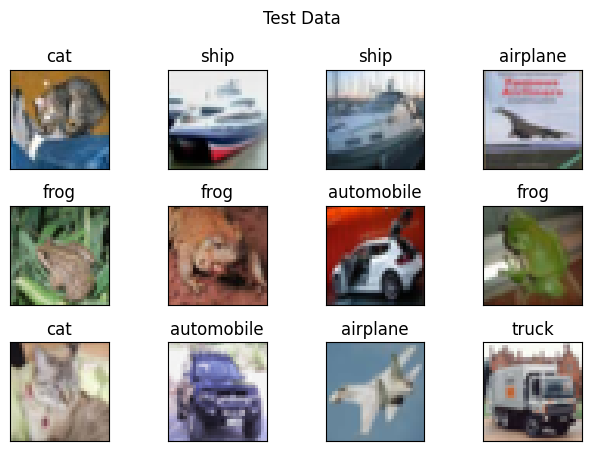

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# View the Training and Test Data
train_CIFAR = datasets.CIFAR10('./data', train=True, download=True)
test_CIFAR = datasets.CIFAR10('./data', train=False, download=True)

def showSampleImages(dataSet, title):
    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.tight_layout()
        img, label = dataSet[i]
        plt.imshow(img, cmap='gray')
        plt.title(dataSet.classes[label])
        plt.xticks([])
        plt.yticks([])

print('CIFAR classes :',train_CIFAR.classes)
showSampleImages(train_CIFAR, "Train Data")
showSampleImages(test_CIFAR, "Test Data")

#### 2.1 Analyse the Dataset and find the Mean and Standard Deviation

Files already downloaded and verified
------ CIFAR10 Dataset Type and Classes ------
exp_CIFAR type =>  <class 'numpy.ndarray'>
------ CIFAR10 Sample Image - InTensor  ------
Files already downloaded and verified


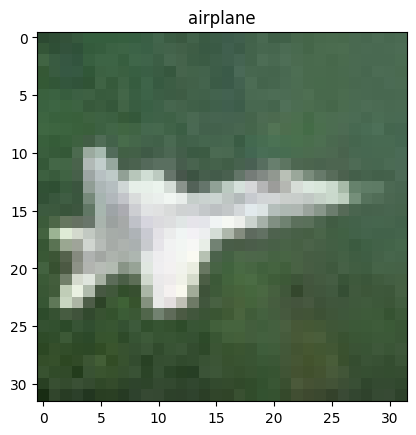

------ CIFAR10 Dataset MEAN & STD_DEV ------
Shape of CIFAR10 => torch.Size([3, 32, 32]) torch.float32
Mean of CIFAR10 =>  tensor([0.4914, 0.4822, 0.4465])
Std Dev of CIFAR10 =>  tensor([0.2470, 0.2435, 0.2616])
------ CIFAR10 Sample Image - Normalized ------


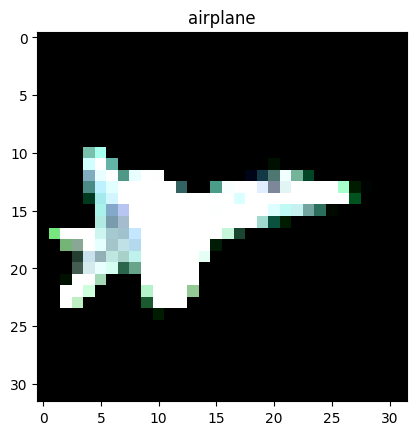

In [3]:
# Index of the sample image
idx = 77

# Download the dataset
exp_CIFAR = datasets.CIFAR10('./data', train=True, download=True)

print('------ CIFAR10 Dataset Type and Classes ------')
print('exp_CIFAR type => ',type(exp_CIFAR.data))

print('------ CIFAR10 Sample Image - InTensor  ------')
tns_CIFAR = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
img_t,label = tns_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

print('------ CIFAR10 Dataset MEAN & STD_DEV ------')
imgs = torch.stack([img_t for img_t ,_ in tns_CIFAR],dim=3)
imgs.shape
print('Shape of CIFAR10 =>', img_t.shape, img_t.dtype)
print('Mean of CIFAR10 => ',imgs.view(3,-1).mean(dim=1))
print('Std Dev of CIFAR10 => ',imgs.view(3, -1).std(dim=1))

print('------ CIFAR10 Sample Image - Normalized ------')
trs_CIFAR = datasets.CIFAR10('./data', train=True, download=False, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4915, 0.4823, 0.4468),
                         (0.2470, 0.2435, 0.2616))
]))
img_t,label = trs_CIFAR[idx]
plt.imshow(img_t.permute(1,2,0))    # we have to use permute to change the order of the axes from C × H × W to H × W × C to match what Matplotlib expects.
plt.title(exp_CIFAR.classes[label])
plt.show()

#### 2.2 Defining Train and Test Phase Transformartions

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean_val = [0.4915, 0.4823, 0.4468]
std_val = [0.2470, 0.2435, 0.2616]

# cutout needs to be half of the image size
cutout_size = 8

# Train Phase Transformations
train_transforms = A.Compose(
    A.Compose([
        A.PadIfNeeded(min_height=40, min_width=40, border_mode=0, value=mean_val, p=1.0),
        A.RandomCrop(height=32, width=32, p=1.0),
        A.HorizontalFlip(),
        # A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.3, rotate_limit=12, p=0.5),
        A.CoarseDropout( max_holes=1, max_height=cutout_size, max_width=cutout_size,
                        min_holes=1, min_height=cutout_size, min_width=cutout_size,
                        fill_value=mean_val, p=0.5, mask_fill_value=None),
        A.Normalize(mean=mean_val, std=std_val),
        ToTensorV2(),
    ])
)

# Test Phase Transformations
test_transforms = A.Compose(A.Compose([
    A.Normalize(mean=mean_val, std=std_val),
    ToTensorV2(),
]))


/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:53: UserWarning: transforms is single transform, but a sequence is expected! Transform will be wrapped into list.
  warnings.warn(


#### 2.3 Download the Dataset and Splitting Train and Test Data

In [5]:
import cv2
import os
import copy
from torch.utils.data import Dataset
from torchvision import datasets

class CIFAR10_Transforms(Dataset):
    def __init__(self, dataset, transforms):
        self.transforms = transforms
        self.dataset = dataset

    def __getitem__(self, idx):
        # Get the image and label from the dataset
        image, label = self.dataset[idx]

        # Apply transformations on the image
        image = self.transforms(image=np.array(image))["image"]

        return image, label

    def __len__(self):
        return len(self.dataset)

    def __repr__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

    def __str__(self):
        return (f"CIFAR10_Transforms(dataset={self.dataset}, transforms={self.transforms})")

train_data = datasets.CIFAR10('../data', train=True, download=True)
test_data = datasets.CIFAR10('../data', train=False, download=True)

train_data = CIFAR10_Transforms(train_data, train_transforms)
test_data = CIFAR10_Transforms(test_data, test_transforms)


100%|██████████| 170498071/170498071 [00:04<00:00, 41219417.33it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


#### 2.4 Dataloader Arguments & Test/Train Dataloaders

In [10]:
# Set the seed for Reproducible results
SEED = 1
set_manualSeed(SEED)

# Dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=2, pin_memory=True) if cuda_availabilty() else dict(shuffle=True, batch_size=64)

# Train DataLoader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# Test DataLoader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)


### Step 3: Initilizing the model

In [12]:
from torchsummary import summary
device = selectDevice()
model = CustomResNet().to(device)
summary(model, input_size=(3, 32, 32))

Using CUDA!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
           Dropout-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,728
         MaxPool2d-6          [-1, 128, 16, 16]               0
       BatchNorm2d-7          [-1, 128, 16, 16]             256
              ReLU-8          [-1, 128, 16, 16]               0
           Dropout-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
          Dropout-13          [-1, 128, 16, 16]               0
           Conv2d-14       

### Step 4: Training and Testing the model

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 666.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.3 MB/s eta 0:00:00


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.33E-01


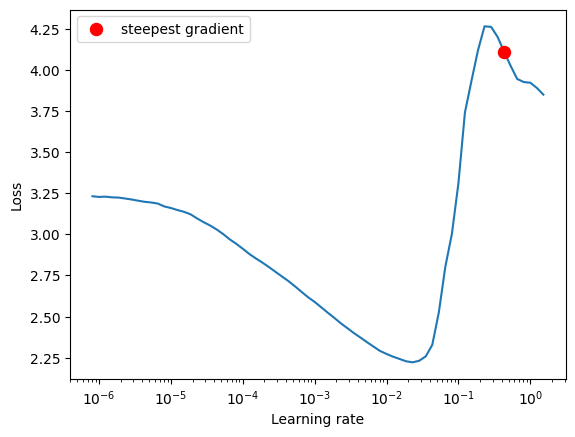

In [14]:
!pip install torch_lr_finder
from torch_lr_finder import LRFinder

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()
lr_finder.reset()

In [15]:
from torch.optim.lr_scheduler import OneCycleLR
num_epoch = 24

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

model = CustomResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-7)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=2e-3, epochs=num_epoch, steps_per_epoch=1, \
                                          pct_start=0.2, div_factor=5)

criterion = F.nll_loss

for epoch in range(num_epoch):
    print('Epoch : ',epoch)
    train_acc, train_losses = train(model, device, train_loader, optimizer, criterion, train_acc, train_losses)
    test_acc, test_losses = test(model, device, test_loader, criterion, test_acc, test_losses)
    scheduler.step()

Epoch :  0


Train: Loss=1.2450 Batch_id=97 Accuracy=42.48: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]


Test set: Average loss: 1.3842, Accuracy: 5091/10000 (50.91%)

Epoch :  1


Train: Loss=0.9592 Batch_id=97 Accuracy=61.60: 100%|██████████| 98/98 [00:21<00:00,  4.53it/s]


Test set: Average loss: 0.9922, Accuracy: 6481/10000 (64.81%)

Epoch :  2


Train: Loss=0.7282 Batch_id=97 Accuracy=70.28: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.6758, Accuracy: 7667/10000 (76.67%)

Epoch :  3


Train: Loss=0.6318 Batch_id=97 Accuracy=75.68: 100%|██████████| 98/98 [00:21<00:00,  4.51it/s]


Test set: Average loss: 0.6512, Accuracy: 7748/10000 (77.48%)

Epoch :  4


Train: Loss=0.5322 Batch_id=97 Accuracy=79.59: 100%|██████████| 98/98 [00:21<00:00,  4.58it/s]


Test set: Average loss: 0.7918, Accuracy: 7418/10000 (74.18%)

Epoch :  5


Train: Loss=0.4767 Batch_id=97 Accuracy=82.10: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


Test set: Average loss: 0.5399, Accuracy: 8186/10000 (81.86%)

Epoch :  6


Train: Loss=0.4466 Batch_id=97 Accuracy=84.47: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Test set: Average loss: 0.6253, Accuracy: 7834/10000 (78.34%)

Epoch :  7


Train: Loss=0.3545 Batch_id=97 Accuracy=85.49: 100%|██████████| 98/98 [00:21<00:00,  4.60it/s]


Test set: Average loss: 0.4305, Accuracy: 8534/10000 (85.34%)

Epoch :  8


Train: Loss=0.3660 Batch_id=97 Accuracy=87.44: 100%|██████████| 98/98 [00:21<00:00,  4.54it/s]


Test set: Average loss: 0.4331, Accuracy: 8507/10000 (85.07%)

Epoch :  9


Train: Loss=0.3439 Batch_id=97 Accuracy=88.31: 100%|██████████| 98/98 [00:24<00:00,  3.98it/s]


Test set: Average loss: 0.3749, Accuracy: 8716/10000 (87.16%)

Epoch :  10


Train: Loss=0.2337 Batch_id=97 Accuracy=89.72: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.3614, Accuracy: 8849/10000 (88.49%)

Epoch :  11


Train: Loss=0.2453 Batch_id=97 Accuracy=90.43: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.3851, Accuracy: 8737/10000 (87.37%)

Epoch :  12


Train: Loss=0.2272 Batch_id=97 Accuracy=91.29: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.3158, Accuracy: 8943/10000 (89.43%)

Epoch :  13


Train: Loss=0.2736 Batch_id=97 Accuracy=92.02: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]


Test set: Average loss: 0.3071, Accuracy: 8980/10000 (89.80%)

Epoch :  14


Train: Loss=0.1896 Batch_id=97 Accuracy=92.72: 100%|██████████| 98/98 [00:21<00:00,  4.59it/s]


Test set: Average loss: 0.3368, Accuracy: 8910/10000 (89.10%)

Epoch :  15


Train: Loss=0.1801 Batch_id=97 Accuracy=93.64: 100%|██████████| 98/98 [00:21<00:00,  4.66it/s]


Test set: Average loss: 0.2788, Accuracy: 9087/10000 (90.87%)

Epoch :  16


Train: Loss=0.2318 Batch_id=97 Accuracy=94.32: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]


Test set: Average loss: 0.2633, Accuracy: 9153/10000 (91.53%)

Epoch :  17


Train: Loss=0.1650 Batch_id=97 Accuracy=95.06: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]


Test set: Average loss: 0.2612, Accuracy: 9177/10000 (91.77%)

Epoch :  18


Train: Loss=0.1219 Batch_id=97 Accuracy=95.55: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]


Test set: Average loss: 0.2503, Accuracy: 9197/10000 (91.97%)

Epoch :  19


Train: Loss=0.1535 Batch_id=97 Accuracy=96.00: 100%|██████████| 98/98 [00:21<00:00,  4.52it/s]


Test set: Average loss: 0.2391, Accuracy: 9208/10000 (92.08%)

Epoch :  20


Train: Loss=0.1101 Batch_id=97 Accuracy=96.35: 100%|██████████| 98/98 [00:21<00:00,  4.63it/s]


Test set: Average loss: 0.2346, Accuracy: 9262/10000 (92.62%)

Epoch :  21


Train: Loss=0.1029 Batch_id=97 Accuracy=96.44: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.2324, Accuracy: 9252/10000 (92.52%)

Epoch :  22


Train: Loss=0.1228 Batch_id=97 Accuracy=96.53: 100%|██████████| 98/98 [00:20<00:00,  4.68it/s]


Test set: Average loss: 0.2309, Accuracy: 9246/10000 (92.46%)

Epoch :  23


Train: Loss=0.0844 Batch_id=97 Accuracy=96.67: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]


Test set: Average loss: 0.2311, Accuracy: 9263/10000 (92.63%)



### Step 5: Analyze Training, Testing Loss and Accuracy

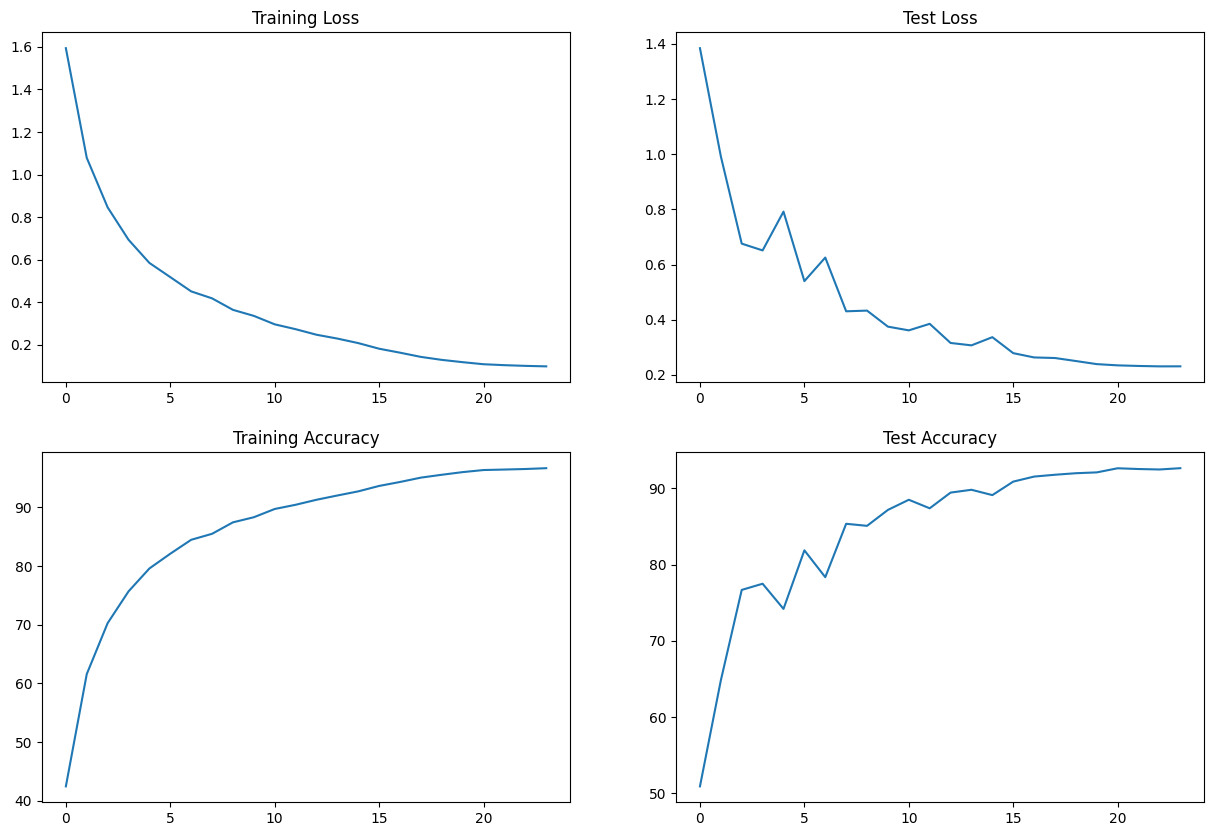

In [16]:
viewAnalysis(train_losses, train_acc, test_losses, test_acc)

# Model

<!--
    TODO:
        • Model to have 200K params
        • Acheive 85% accuracy
        • No limit on Epoch
        • Total RF to be greater than 44
-->

In [7]:
class CustomResNet(nn.Module):

    dropout_value = 0.1

    def __init__(self):
        super().__init__()
        # PrepLayer - Conv 3x3 s1, p1) >> BN >> RELU [64k]
        self.prep_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer1 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [128k]
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer1 - R1 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [128k]
        self.layer1_resblock = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer2 - Conv 3x3 [256k], MaxPooling2D, BN, ReLU
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # Layer3 - X = Conv 3x3 (s1, p1) >> MaxPool2D >> BN >> RELU [512k]
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.MaxPool2d(kernel_size=2),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )
        # Layer3 - R2 = ResBlock( (Conv-BN-ReLU-Conv-BN-ReLU))(X) [512k]
        self.layer3_resblock = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), padding=1, stride=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(self.dropout_value)
        )

        # MaxPooling with Kernel Size 4
        self.maxpool = nn.MaxPool2d(kernel_size=4)

        # FC Layer
        self.fc = nn.Linear(512, 10)

    def forward(self, x):
        # PrepLayer
        x = self.prep_layer(x)

        # Layer 1
        x = self.layer1(x)
        r1 = self.layer1_resblock(x)
        x = x + r1

        # Layer 2
        x = self.layer2(x)

        # Layer 3
        x = self.layer3(x)
        r2 = self.layer3_resblock(x)
        x = x + r2

        # MaxPooling
        x = self.maxpool(x)

        # FC Layer
        x = x.view(x.shape[0], -1)
        x = self.fc(x)

        # Softmax
        return F.log_softmax(x, dim=-1)


# Utility functions

### utils.py

In [8]:
""" Function to mount Google Drive to your workspace """
def mountDrive():
    from google.colab import drive
    drive.mount('/content/drive')

""" Checking if we have CUDA enabled GPU or not, """
def cuda_availabilty():
    return torch.cuda.is_available()

""" Function to set manual seed for reproducible results """
def set_manualSeed(seed):
    # Sets the seed for PyTorch's Random Number Generator
    torch.manual_seed(seed)
    if cuda_availabilty():
        torch.cuda.manual_seed(seed)

""" Function to select Device """
def selectDevice():
    using_cuda = cuda_availabilty()
    print("Using CUDA!" if using_cuda else "Not using CUDA.")
    # if so select "cuda" as device for processing else "cpu"
    device = torch.device("cuda" if using_cuda else "cpu")
    return device

""" Function to download the MNIST dataset """
def download_MNIST(train, transform):
    from torchvision import datasets
    return datasets.MNIST('../data', train=train, download=True, transform=transform)

""" Function to download the CIFAR10 dataset """
def download_CIFAR10(train, transform):
    from torchvision import datasets
    return datasets.CIFAR10('../data', train=train, download=True, transform=transform)

""" Function to view the statistics around our data """
def stats_dataset(data):
    train_data = data.train_data
    train_data = data.transform(train_data.numpy())

    print('[Train]')
    print(' - Numpy Shape:', data.train_data.cpu().numpy().shape)
    print(' - Tensor Shape:', data.train_data.size())
    print(' - min:', torch.min(train_data))     # Min Pixel Value
    print(' - max:', torch.max(train_data))     # Max Pixel Value
    print(' - mean:', torch.mean(train_data))
    print(' - std:', torch.std(train_data))
    print(' - var:', torch.var(train_data))

"""Funciton to view the samples in dataset """
def view_dataset(data_loader, title):
    import matplotlib.pyplot as plt

    batch_data, batch_label = next(iter(data_loader))

    fig = plt.figure()
    plt.suptitle(title)

    for i in range(12):
      plt.subplot(3,4,i+1)
      plt.tight_layout()
      plt.imshow(batch_data[i].squeeze(0).permute(1,2,0), cmap='gray')
      plt.title(batch_label[i].item())
      plt.xticks([])
      plt.yticks([])

""" Function to Get Correct Prediction Count """
def GetCorrectPredCount(pPrediction, pLabels ):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

""" Function to view the Training and Testing Accuracy and Loss """
def viewAnalysis(train_losses, train_acc, test_losses, test_acc):
    import matplotlib.pyplot as plt

    fig, axs = plt.subplots(2,2,figsize=(15,10))
    axs[0, 0].plot(train_losses)
    axs[0, 0].set_title("Training Loss")
    axs[1, 0].plot(train_acc)
    axs[1, 0].set_title("Training Accuracy")
    axs[0, 1].plot(test_losses)
    axs[0, 1].set_title("Test Loss")
    axs[1, 1].plot(test_acc)
    axs[1, 1].set_title("Test Accuracy")

""" Function to plot the misClassified Images """
def plotMisClassifiedImages(model, device, test_loader,classes):
    classes = test_data.classes
    model.eval()
    misClassifiedImages = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            idxs_mask = ~pred.eq(target.view_as(pred)).view(-1)
            misClassifiedImages.extend([(data[i], pred[i], target[i]) for i in range(len(idxs_mask)) if idxs_mask[i]])
            if len(misClassifiedImages) >= 10:
                break

    misClassifiedImages = misClassifiedImages[:10]

    fig, axes = plt.subplots(5, 2, figsize=(8, 10))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, (img, pred, target) in enumerate(misClassifiedImages):
        img, pred, target = img.cpu().numpy(), pred.cpu(), target.cpu()
        ax = axes[i//2, i%2]
        img = img.transpose((1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean  # De-normalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f'Predicted: {classes[pred.item()]}, Actual: {classes[target.item()]}')
        ax.axis('off')

    plt.show()

In [9]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, criterion, train_acc, train_losses):
    model.train()
    pbar = tqdm(train_loader)

    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        # Get a batch of samples
        data, target = data.to(device) , target.to(device)
        # Initilizes the gradients to zero
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate Loss
        loss = criterion(pred, target)
        train_loss+=loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100*correct/processed)
    train_losses.append(train_loss/len(train_loader))
    return train_acc, train_losses

def test(model, device, test_loader, criterion, test_acc, test_losses):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)

            test_loss += criterion(output, target, reduction='sum').item()  # Sum up batch loss
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_acc, test_losses